In [1]:
!pip install --user git+https://github.com/rtqichen/torchdiffeq.git

project_dir = "odenet"
import sys
if False: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/"+project_dir
    sys.path.append(root)
else: # Local
    root = './'

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-tcz_zke5
  Running setup.py bdist_wheel for torchdiffeq ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-wn34ug2m/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# For the aws instance
!pip install --user git+https://github.com/rtqichen/torchdiffeq.git
!pip install --user torchvision

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-zt6rmchm
  Running setup.py bdist_wheel for torchdiffeq ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-53_r2s00/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import torch
import torch.nn.init as init

from matplotlib import pylab as plt
from odenet import datasets
from odenet.odenet_cifar10 import ODEResNet
from odenet import refine_train

import importlib
importlib.reload(refine_train)
from odenet.helper import set_seed, get_device, which_device
#importlib.reload(odenet_cifar10)

In [4]:
set_seed()
device = get_device()

Connected to a GPU


In [5]:
refset,trainset,trainloader,testset,testloader = datasets.get_dataset('CIFAR10',root='../data/')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


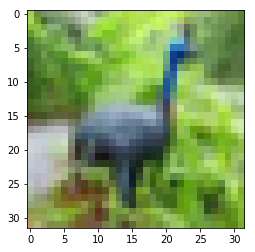

In [6]:
plt.imshow(refset.data[6],cmap='gray')

In [7]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)
            
    if isinstance(m, torch.nn.Conv2d):
        if m.weight is not None:
            init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias, 0.0)        


In [8]:
def do_a_train_set(ALPHA, method, N_epochs, N_adapt, lr, lr_decay=0.1, epoch_update=[10], weight_decay=1e-5):
    
    np.random.seed(123)
    torch.manual_seed(123)

    
    model = ODEResNet(ALPHA=ALPHA, method=method, in_channels=3).to(device)
    model.apply(weights_init)
    
    #==============================================================================
    # Model summary
    #==============================================================================
    print(model)
    print('**** Setup ****')
    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    print('************')
    


    res = refine_train.train_adapt(model, trainloader, testloader, torch.nn.CrossEntropyLoss(),
                N_epochs, N_adapt, lr=lr, lr_decay=lr_decay, epoch_update=epoch_update, weight_decay=weight_decay, 
                                   device=device)
    #plt.semilogy(res[1])
    #for r in res[2]:
    #    plt.axvline(r,color='k')
    return res

In [9]:
stash = {}
for method in ['euler','rk4','midpoint']:
#for method in ['euler']:
    res = do_a_train_set(16, method, N_epochs=90, N_adapt=[], lr=1e-1, lr_decay=0.1, epoch_update=[30, 60, 80], weight_decay=0)
    stash[method] = res

ODEResNet(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ODEBlock(
      (net): ShallowConv2DODE(
        (L1): Conv2DODE()
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (L2): Conv2DODE()
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ODEBlock(
      (net): ShallowConv2DODE(
        (L1): Conv2DODE()
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (L2): Conv2DODE()
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

KeyboardInterrupt: 

In [ ]:
for k,(models,losses,refine_steps) in stash.items():
    plt.semilogy(losses,label=k)
    for r in refine_steps:
        plt.axvline(r,color='k')
plt.ylim(top=6)
plt.legend()
plt.show()

In [ ]:
for k,(model_list,losses,refine_steps) in stash.items():
    print(k)
    for m in model_list:
        print(refine_train.model_acc(m,testloader))

In [ ]:
refset.classes

In [ ]:
#torch.save(stash['rk4'][0], 'results/resnet_rk4.pkl')
#torch.save(stash['euler'][0], 'results/resnet_euler.pkl')